In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [11]:
df0 = pd.read_excel("Online Retail.xlsx", engine="openpyxl")

In [12]:
print(df0)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [13]:
df0[df0.isnull().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0,nan,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,3,nan,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,3,nan,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,1,nan,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,2,nan,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4,nan,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4,nan,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,5,nan,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,11,nan,United Kingdom


In [14]:
# delete rows in which we cannot identify the customer
df1 = df0.copy()
df1 = df1[pd.notnull(df1["CustomerID"])]

In [15]:
# are any missing values left?
booMiss = df1.isnull().values.any()
if booMiss:
    _ = [print(k,":",v) for k,v in df1.isnull().sum().items() if v!=0]   # number missing


In [16]:
# Review numerical variables
df1.describe()

,Quantity,UnitPrice,CustomerID
count,"406,829","406,829","406,829"
mean,12,3,"15,288"
std,249,69,"1,714"
min,"-80,995",0,"12,346"
25%,2,1,"13,953"
50%,5,2,"15,152"
75%,12,4,"16,791"
max,"80,995","38,970","18,287"


In [17]:
df1[df1["Quantity"] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,28,"14,527",United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,5,"15,311",United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,2,"17,548",United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0,"17,548",United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0,"17,548",United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,1,"14,397",United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,225,"15,498",United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,11,"15,311",United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1,"17,315",United Kingdom


In [18]:
# restrict to transactions with positive quantities
df1 = df1[df1["Quantity"] > 0]

In [19]:
# datetime to date format
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"]).dt.date #normalize()
#df1.set_index("InvoiceDate", inplace=False)

In [20]:
# treat CustomerID as a categorical variable
df1["CustomerID"] = df1["CustomerID"].astype(np.int64).astype(object)

In [21]:
# review the categorical variables
df1.describe(include='object').T

,count,unique,top,freq
InvoiceNo,397924,18536,576339,542
StockCode,397924,3665,85123A,2035
Description,397924,3877,WHITE HANGING HEART T-LIGHT HOLDER,2028
InvoiceDate,397924,305,2011-11-06,3423
CustomerID,397924,4339,17841,7847
Country,397924,37,United Kingdom,354345


In [22]:
# delete columns that are not useful
try:
    d1 = df1.drop(["InvoiceNo", "StockCode", "Description", "Country"], axis=1, inplace=True)
except:
    pass
df1.describe(include='object').T

,count,unique,top,freq
InvoiceDate,397924,305,2011-11-06,3423
CustomerID,397924,4339,17841,7847


In [23]:
# revenues = quantity * unitprice
df1["Revenues"] = df1["Quantity"] * df1["UnitPrice"]
df1

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenues
0,6,2010-12-01,3,17850,15
1,6,2010-12-01,3,17850,20
2,8,2010-12-01,3,17850,22
3,6,2010-12-01,3,17850,20
4,6,2010-12-01,3,17850,20
...,...,...,...,...,...
541904,12,2011-12-09,1,12680,10
541905,6,2011-12-09,2,12680,13
541906,4,2011-12-09,4,12680,17
541907,4,2011-12-09,4,12680,17


In [24]:
df1.describe()

,Quantity,UnitPrice,Revenues
count,"397,924","397,924","397,924"
mean,13,3,22
std,180,22,309
min,1,0,0
25%,2,1,5
50%,6,2,12
75%,12,4,20
max,"80,995","8,143","168,470"


In [25]:
date_grp = df1.groupby(df1["InvoiceDate"]).mean()

In [26]:
date_grp

,Quantity,UnitPrice,Revenues
InvoiceDate,,,
2010-12-01,12,3,24
2010-12-02,16,3,24
2010-12-03,11,3,22
2010-12-05,6,3,12
2010-12-06,8,3,16
...,...,...,...
2011-12-05,11,3,17
2011-12-06,11,2,18
2011-12-07,19,3,32


In [27]:
# recency, frequency, T
dfx = df1[df1["CustomerID"] == 14527]


In [29]:
dfx.describe()

,Quantity,UnitPrice,Revenues
count,972,972,972
mean,2,5,9
std,3,4,8
min,1,0,0
25%,1,2,4
50%,1,4,8
75%,2,8,10
max,36,17,88


In [30]:
# age T:
xmaxall_date = df1["InvoiceDate"].max()


population maximum date: 2011-12-09
T: 369


In [36]:
print("population maximum date:", xmaxall_date)

print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

xmax_date = dfx["InvoiceDate"].max()
print("xmax_date:", xmax_date)

xmin_date = dfx["InvoiceDate"].min()
print("xmax_date:", xmin_date)

xage = (xmaxall_date - xmin_date).days                    # age T

population maximum date: 2011-12-09
T: 369
frequency: 53
xmax_date: 2011-12-07
xmax_date: 2010-12-05


In [37]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df1["InvoiceDate"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df1,
        customer_id_col = "CustomerID",
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues",
        calibration_period_end = max_cal_date,
        observation_period_end = max_date,
        freq = "D")

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2011-12-09
end of calibration period: 2011-04-13
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0,0,85,0,0,0,240
12347,2,121,127,556,4,25,240
12348,2,110,118,297,1,103,240
12350,0,0,70,0,0,0,240
12352,3,34,56,422,3,20,240
...,...,...,...,...,...,...,...
18270,0,0,26,0,1,29,240
18272,0,0,6,0,5,18,240
18273,0,0,17,0,2,76,240


In [38]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"2,299","2,299","2,299","2,299","2,299","2,299","2,299"
mean,1,31,79,176,3,28,240
std,2,44,43,438,5,113,0
min,0,0,0,0,0,0,240
25%,0,0,42,0,1,3,240
50%,0,0,82,0,2,16,240
75%,1,65,124,252,4,23,240
max,35,133,133,"8,030",96,"4,307",240


In [39]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.591
1.000    0.184
2.000    0.092
3.000    0.051
4.000    0.027
5.000    0.017
6.000    0.009
7.000    0.008
8.000    0.004
9.000    0.004
10.000   0.003
11.000   0.001
13.000   0.001
14.000   0.001
17.000   0.001
Name: frequency_cal, dtype: float64

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

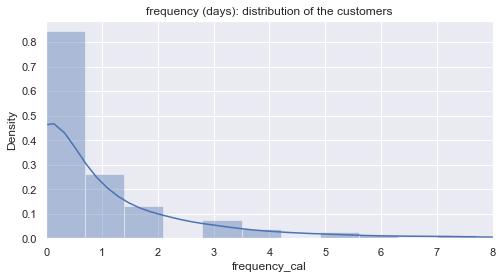

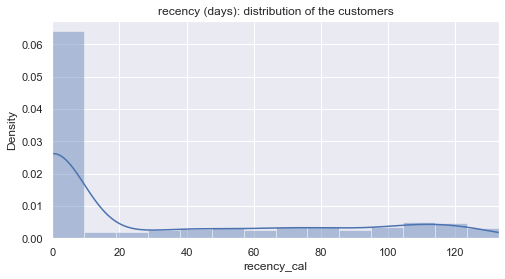

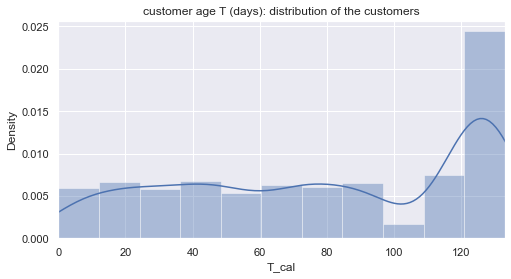

In [40]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()


# training
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


# training
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")


# training
fig = plt.figure(figsize=(8, 4))
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

In [41]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"],
        recency = df_ch["recency_cal"],
        T = df_ch["T_cal"],
        weights = None,
        verbose = True,
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: 0.079518
         Iterations: 49
         Function evaluations: 50
         Gradient evaluations: 50


<lifetimes.BetaGeoFitter: fitted with 2299 subjects, a: 0.00, alpha: 54.76, b: 0.03, r: 0.69>

<Figure size 864x864 with 0 Axes>

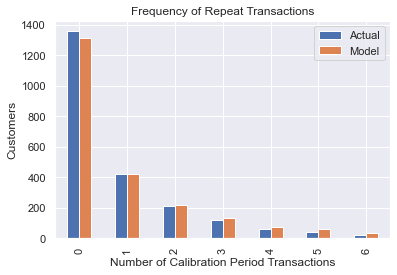

In [42]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

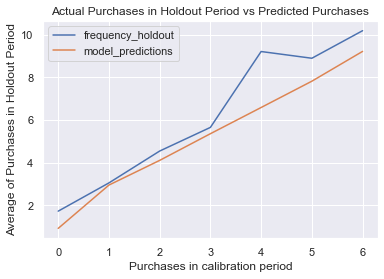

In [43]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7))
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

In [44]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df1,
    customer_id_col = "CustomerID",
    datetime_col = "InvoiceDate",
    monetary_value_col = "Revenues",
    observation_period_end = max_date,
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0,0,325,0
12347,6,365,367,600
12348,3,283,358,301
12349,0,0,18,0
12350,0,0,310,0
...,...,...,...,...
18280,0,0,277,0
18281,0,0,180,0
18282,1,119,126,78


In [45]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"4,339","4,339","4,339","4,339"
mean,3,131,223,307
std,6,132,118,"2,612"
min,0,0,0,0
25%,0,0,112,0
50%,1,93,248,177
75%,3,252,326,360
max,131,373,373,"168,470"


In [46]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"],
        recency = df_rft["recency"],
        T = df_rft["T"],
        weights = None,
        verbose = True,
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.709794
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.827,0.027,0.774,0.879
alpha,68.910,2.618,63.779,74.041
a,0.002,0.006,-0.010,0.014
b,2.967,6.267,-9.317,15.250


131


<Figure size 864x864 with 0 Axes>

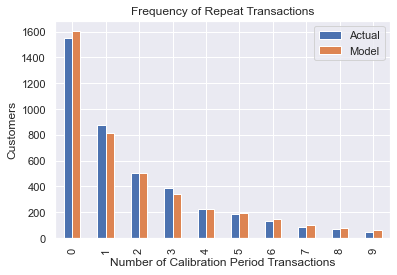

In [47]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))
max_T = int(df_rft["T"].max())
max_rec = int(df_rft["recency"].max())
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,
            max_frequency = 10);

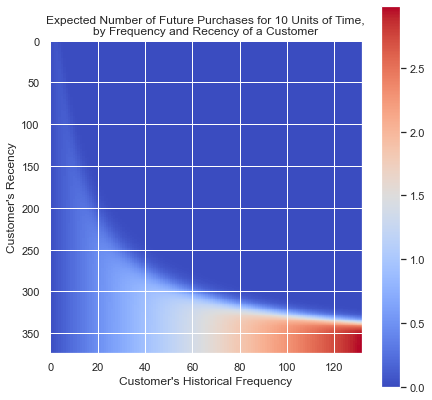

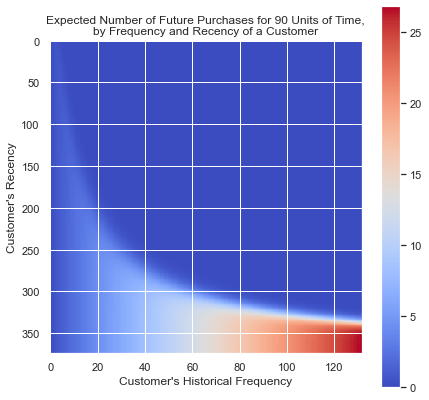

In [48]:
# helper function: plot expected number of future purchases a customer with
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7))
    plot_frequency_recency_matrix(
            model = bgf,
            T = t,
            max_frequency = max_freq,
            max_recency = max_rec);


# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [49]:
# predict purchases for a selected customer for t days
t = 30
custID = 12748

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t,
                        df_rft_C["frequency"],
                        df_rft_C["recency"],
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 12748 : expected number of purchases within 30 days = 7.7


In [50]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t,
                    df["frequency"],
                    df["recency"],
                    df["T"])


# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
12346,0.0,0.0,325.0,0.0,0.0,0.1,0.1,0.2
12347,6.0,365.0,367.0,599.7,0.2,0.5,0.9,1.4
12348,3.0,283.0,358.0,301.5,0.1,0.3,0.5,0.8
12349,0.0,0.0,18.0,0.0,0.1,0.3,0.6,0.9
12350,0.0,0.0,310.0,0.0,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...
18280,0.0,0.0,277.0,0.0,0.0,0.1,0.1,0.2
18281,0.0,0.0,180.0,0.0,0.0,0.1,0.2,0.3
18282,1.0,119.0,126.0,77.8,0.1,0.3,0.6,0.8


In [51]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
14911,131.0,372.0,373.0,"1,093.7",3.0,8.9,17.9,26.8
12748,113.0,373.0,373.0,298.4,2.6,7.7,15.5,23.2
17841,111.0,372.0,373.0,364.5,2.5,7.6,15.2,22.8
15311,89.0,373.0,373.0,677.7,2.0,6.1,12.2,18.3
14606,88.0,372.0,373.0,135.9,2.0,6.0,12.1,18.1
12971,70.0,369.0,372.0,159.2,1.6,4.8,9.6,14.5
13089,65.0,367.0,369.0,893.7,1.5,4.5,9.0,13.5
14527,53.0,367.0,369.0,155.0,1.2,3.7,7.4,11.1
13798,52.0,371.0,372.0,706.7,1.2,3.6,7.2,10.8


predicted avg number of purchases over next 90 days:


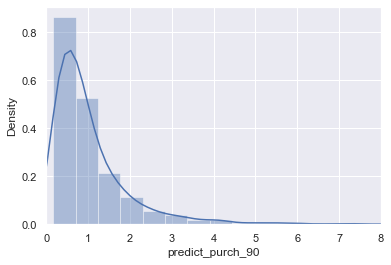

In [52]:
print("predicted avg number of purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

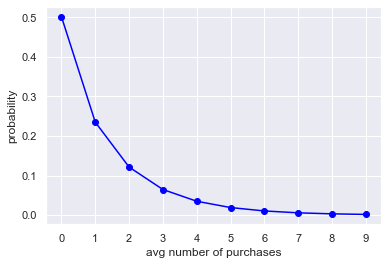

In [53]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p



  # call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

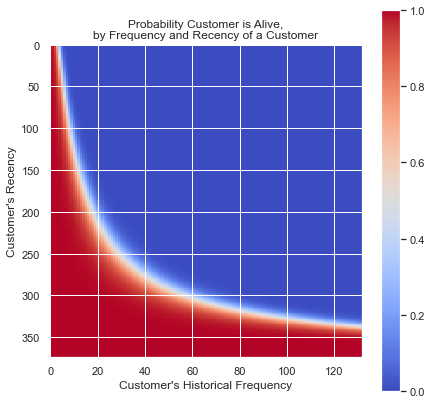

In [54]:
# probability that a customer has not churned (= is alive), based on
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7))
plot_probability_alive_matrix(
            model = bgf,
            max_frequency = max_freq,
            max_recency = max_rec);

In [55]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"],
        recency = df_rft["recency"],
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00","4,339.00"
mean,2.86,130.74,222.78,306.94,0.12,0.36,0.72,1.08,1.00
std,5.95,132.21,117.88,"2,612.45",0.14,0.42,0.85,1.27,0.01
min,0.00,0.00,0.00,0.00,0.02,0.06,0.11,0.17,0.75
25%,0.00,0.00,112.00,0.00,0.05,0.15,0.30,0.45,1.00
50%,1.00,93.00,248.00,176.94,0.09,0.26,0.51,0.77,1.00
75%,3.00,252.00,326.00,360.16,0.14,0.42,0.85,1.27,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


In [58]:
df_rft[df_rft["prob_alive"] < 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
13093,6.00,98.00,373.00,"1,172.18",0.13,0.39,0.79,1.18,0.85
15107,5.00,61.00,372.00,40.70,0.10,0.30,0.60,0.89,0.75
15235,9.00,156.00,373.00,240.89,0.20,0.59,1.18,1.77,0.89
16725,5.00,69.00,371.00,131.77,0.11,0.32,0.65,0.97,0.81


In [60]:
# select a customer

custID = 15107

df1C = df1[df1["CustomerID"] == custID]
df1C.describe()


,Quantity,UnitPrice,Revenues
count,17.00,17.00,17.00
mean,10.00,5.26,18.79
std,13.56,4.82,12.26
min,1.00,0.00,0.00
25%,2.00,0.85,12.75
50%,6.00,2.95,17.00
75%,12.00,8.50,19.90
max,48.00,14.95,51.00


In [63]:
# X selected customer: cumulative transactions
max_date = df1["InvoiceDate"].max()
min_date = df1["InvoiceDate"].min()
span_days = (max_date - min_date).days
print(span_days)

373


customer 15107 : probability of being alive over time


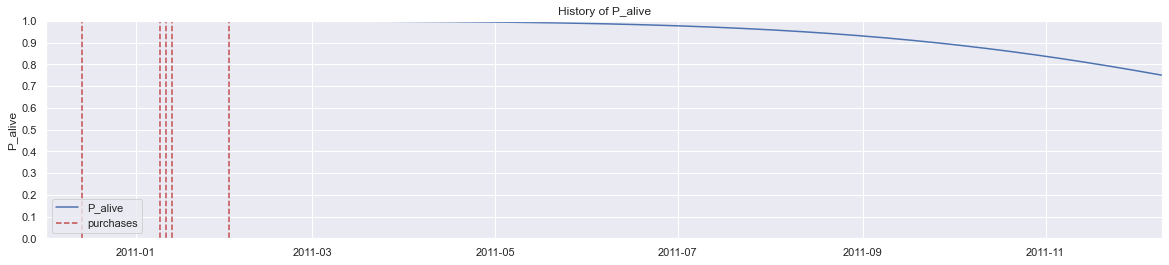

In [64]:

# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf,
                    t = span_days,
                    transactions = df1C,
                    datetime_col = "InvoiceDate");


In [65]:


 # selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf,
            t = span_days,
            transactions = df1C,
            datetime_col = "InvoiceDate");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 15107 's probability of being alive, development over time


count   374.00
mean      0.95
std       0.07
min       0.75
25%       0.92
50%       0.99
75%       1.00
max       1.00
dtype: float64

In [66]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00","2,790.00"
mean,4.45,203.33,260.12,477.36,0.16,0.48,0.95,1.43,1.00
std,6.93,111.46,101.48,"3,245.62",0.16,0.49,0.97,1.46,0.01
min,1.00,1.00,9.00,1.00,0.04,0.12,0.24,0.37,0.75
25%,1.00,106.00,197.25,187.16,0.07,0.22,0.45,0.67,1.00
50%,3.00,211.00,284.00,309.47,0.12,0.36,0.71,1.07,1.00
75%,5.00,301.75,358.00,458.37,0.18,0.55,1.11,1.66,1.00
max,131.00,373.00,373.00,"168,469.60",2.98,8.95,17.90,26.84,1.00


In [67]:
# Gamma-Gamma model requires a Pearson correlation close to 0
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.016


In [68]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],
        weights = None,
        verbose = True,
        tol = 1e-06,
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.176,0.186,3.811,4.541
q,2.415,0.070,2.279,2.552
v,149.875,8.304,133.600,166.151


In [69]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.12


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,
12347,6.000,365.000,367.000,599.702,0.157,0.470,0.939,1.409,1.000,591.285,599.702,-8.417
12348,3.000,283.000,358.000,301.480,0.090,0.269,0.537,0.806,0.999,315.769,301.480,14.289
12352,6.000,260.000,296.000,368.257,0.187,0.561,1.122,1.683,1.000,372.213,368.257,3.956
12356,2.000,303.000,325.000,269.905,0.072,0.215,0.430,0.645,0.999,294.878,269.905,24.973
12358,1.000,149.000,150.000,683.200,0.083,0.250,0.500,0.750,0.999,622.216,683.200,-60.984


In [70]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,
        frequency = df_rftv["frequency"],
        recency = df_rftv["recency"],
        T = df_rftv["T"],
        monetary_value = df_rftv["monetary_value"],
        time = LIFE,
        freq = "D",
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"2,790.000","2,847.307","10,288.066",156.692,757.685,"1,358.997","2,543.874","292,616.545"
frequency,"2,790.000",4.454,6.930,1.000,1.000,3.000,5.000,131.000
recency,"2,790.000",203.329,111.460,1.000,106.000,211.000,301.750,373.000
T,"2,790.000",260.121,101.480,9.000,197.250,284.000,358.000,373.000
monetary_value,"2,790.000",477.359,"3,245.622",1.000,187.165,309.473,458.371,"168,469.600"
predict_purch_10,"2,790.000",0.159,0.162,0.041,0.075,0.119,0.185,2.983
predict_purch_30,"2,790.000",0.476,0.486,0.122,0.224,0.356,0.554,8.949
predict_purch_60,"2,790.000",0.952,0.973,0.244,0.448,0.711,1.107,17.896
predict_purch_90,"2,790.000",1.428,1.459,0.365,0.672,1.067,1.660,26.843
prob_alive,"2,790.000",0.998,0.007,0.752,0.999,0.999,1.000,1.000


In [72]:
df_rftv.sort_values(by="CLV", ascending=False)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,,
16446,"292,616.545",1.000,205.000,205.000,"168,469.600",0.067,0.200,0.400,0.600,0.999,"125,940.166","168,469.600","-42,529.434"
14646,"233,600.682",44.000,353.000,354.000,"6,366.706",1.060,3.180,6.359,9.537,1.000,"6,321.425","6,366.706",-45.281
18102,"190,660.080",25.000,367.000,367.000,"9,349.477",0.592,1.777,3.554,5.331,1.000,"9,230.351","9,349.477",-119.126
17450,"156,943.374",26.000,359.000,367.000,"7,404.690",0.615,1.846,3.692,5.537,1.000,"7,315.109","7,404.690",-89.581
14096,"137,877.760",16.000,97.000,101.000,"4,071.434",0.990,2.970,5.939,8.908,1.000,"3,996.161","4,071.434",-75.273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12755,182.803,1.000,85.000,365.000,17.550,0.042,0.126,0.252,0.377,0.996,125.048,17.550,107.498
14865,177.783,1.000,365.000,372.000,15.000,0.041,0.124,0.248,0.373,0.999,123.144,15.000,108.144
17194,176.626,1.000,87.000,360.000,10.000,0.042,0.127,0.254,0.382,0.996,119.409,10.000,109.409
